**MEJORAS:** 


* Se mejora la sección de experimentos en BY implementando una forma de intersectar conforme a los índices y así reconstruir al final el arreglo.
* Se reconstruyen gráficas de tiempos a partir de los últimos experimentos
* Se agregan las observaciones en el análisis de gráficas y en las conclusiones 

# Introducción
En esta práctica se explora el rendimiento que tendrán diferentes algoritmos de intersección como el algoritmo de Baeza-Yates [[1](#referencias)] (en adelante BY), de Barbay & Kenyon [[2](#referencias)] (en adelante BK) y el de Melding (en adelante ME), este último se hizo conforme a lo visto en el sitio [[3](#referencias)] lo cual también se puede encontrar en el artículo [[4](#referencias)] como un algoritmo de menos comparaciones. 

La medición de rendimiento que se aborda en la práctica se basa en la medición de tiempos de ejecución, número de comparaciones hechas en el algoritmo y tamaño de las intersecciones encontradas. Para cada evaluación de los algoritmos se utilizaron las listas proporcionadas `postinglists-for-intersection-A-k=2`, `postinglists-for-intersection-B-k=3` y `postinglists-for-intersection-C-k=4`. 

El algoritmo de BY se parametrizó con los algoritmos de búsqueda binaria y no acotada b1 conforme al sitio [[3](#referencias)] y b2 conforme al artículo [[5](#referencias)], los cuales sirvieron para obtener diferentes medidas de desempeño. Dado que BY está diseñado para intersectar 2 conjuntos se implementó una tercera función que sirviera para intersectar los conjuntos restantes como lo indica en [[5](#referencias)] aunque no se consideró mantener el orden de los elementos pasando la primera intersección, aún así se tuvieron buenos desempeños. 

Para la medición de desempeño se hizo de forma que primero se tomaran las mediciones de intersecciones y número de comparaciones hechas y posteriormente la medición de tiempos de ejecución, ésta última se hizo usando la biblioteca de `BenchmarkTools` para que por algoritmo se tomaran 1000 muestras y solo 1 evaluación, con ello aseguramos que se tengan buenos datos de ejecución y así poder elegir la media de los tiempos.

Se agilizaron las mediciones de métricas mediante iteraciones que permitieran recorrer cada lista y posteriormente recorrer los conjuntos a intersectar, solamente para el caso de BY se incorpora un ciclo anidado más para cambiar la parametrización a b1 y b2, todos los datos se guardaron en dataframes lo cual permitió que se graficaran de forma rápida los datos. Se almacenaron las medidas tomadas para futuros análisis.

Para la última parte de gráficas, se realizaron dos veces para las métricas de tiempos y número de operaciones ya que ME al tener valores mucho mayores no se visualizaba con claridad el desempeño del resto de los algoritmos.


# Desarrollo
En esta sección se muestra la implementación de los algortimos Baeza-Yates (BY), Barbay & Kenyon (BK) y finalmente el de Melding (ME), dado que se parametrizará el de BY con `binarysearch`, y búsqueda no acotada `b1` y `b2` de acuerdo a [[5](#referencias)] se muestra primero la implementación de éstos primero continuando con la implementación de BY, BK y finalmente ME.

## Implementación de algoritmos

### Búsqueda no acotada
La implementación del algoritmo se hizo basandose en el código del sitio [[6](#referencias)] al cual se le agrega la variable de contar para tener registro de las comparaciones realizadas, se ajustaron los argumentos de forma conveniente para la realización de los experimentos.

In [1]:
function binarysearch(A, x, contar, sp=1, ep=length(A))
    while sp < ep
        contar[] += 1
        mid = div(sp + ep, 2)
        if x <= A[mid]
        contar[] += 1
            ep = mid
        else
            sp = mid + 1
        end
        
    end
    contar[] += 1
    # println("byn ",contar[])
    
    x <= A[sp] ? sp : sp + 1
end

binarysearch (generic function with 3 methods)

La implementación del algoritmo se hizo basandose en el código del sitio [[6](#referencias)] al cual se le agrega la variable de contar para tener registro de las comparaciones realizadas, se ajustaron los argumentos de forma conveniente para la realización de los experimentos.

In [2]:
function b1(A, x, contar, sp=1) 
    n = length(A)
    p = 0
    i = 1
    while sp+i <= n && A[sp+i] < x
        contar[] += 1
        p = i
        i += i
    end
    binarysearch(A, x, contar, sp + p, min(n, sp+i)) 
end

b1 (generic function with 2 methods)

La implementación del algoritmo se hizo basandose en el artículo [[5](#referencias)] al cual se hicieron ajustes sobre como dar el tamaño de paso para encontrar el rango de inserción que es de ${2^2}^i$ y al terminar usa a `b1` para continuar con la búsqueda, se ajustaron los argumentos de forma conveniente para la realización de los experimentos.

In [3]:
function b2(A, x, contar, sp=1)
    n = length(A)
    p = 0
    i = 2 #2^(2^0) 
    k = 0

    while sp+i <= n && A[sp+i] < x
        contar[] += 1
        k += 1
        p = i
        i += 2^(2^k) #debe ser esta

    end
    # println("b2 ", contar[])
    b1(A, x, contar, sp + p)
end

b2 (generic function with 2 methods)

### Baeza-Yates
El algoritmo utilizado es de acuerdo al sitio [[3](#referencias)] el cual realiza intersección entre 2 conjuntos ordenados, de igual forma se agrega la variable `contar`para tener el registro de las comparaciones que se hacen en el algoritmo, se realizan los ajustes del algortimo para que compare indices y al final reconstruya con base en los índices. De forma que la función auxiliar permite usar el algoritmo de BY para la intersección de varios conjuntos, se implementó de forma que siempre esté intersectando 2 conjuntos conforme a [[7](#referencias)] y se estará iterando a través de cada conjunto para intersectarlo con el conjunto resultante de la intersección anterior. 

In [4]:
function interseccion_multi_mejorada!(conjuntos::Vector{Any}, findpos::Function=binarysearch)
    length(conjuntos) < 2 && return conjuntos, 0
    
    # Primera intersección: guardamos índices en lugar de valores
    indices, total_ops = baezayates_indices!([], conjuntos[1], conjuntos[2], findpos)
    
    isempty(indices) && return Int[], total_ops
    
    # Intersecciones subsiguientes
    for i in 3:length(conjuntos)
        indices, ops = intersect_indices!([], indices, conjuntos[1], conjuntos[i], findpos)
        total_ops += ops
        isempty(indices) && break
    end
    
    # Construir el resultado final solo una vez
    result = [conjuntos[1][idx] for idx in indices]
    return result, total_ops
end

function baezayates_indices!(output, A, B, findpos::Function)
    contar = Ref(0)
    result = baezayates_indices!(output, A, 1, length(A), B, 1, length(B), findpos, contar)
    return result, contar[]
end

function baezayates_indices!(output, A, a_sp::Int, a_ep::Int, B, b_sp::Int, b_ep::Int, findpos::Function, contar)
    (a_ep < a_sp || b_ep < b_sp) && return output
    imedian = ceil(Int, (a_ep + a_sp) / 2)
    median = A[imedian]
    encontrada = findpos(B, median, contar, b_sp)
    medpos = min(encontrada, b_ep)
    contar[] += 1
    matches = median == B[medpos]
    
    baezayates_indices!(output, A, a_sp, imedian - 1, B, b_sp, medpos - matches, findpos, contar)
    matches && push!(output, imedian)  # Guardamos el índice en A en lugar del valor
    baezayates_indices!(output, A, imedian + 1, a_ep, B, medpos + matches, b_ep, findpos, contar)
    
    return output
end

function intersect_indices!(output, indices_A, A, B, findpos::Function)
    contar = Ref(0)
    result = intersect_indices!(output, indices_A, 1, length(indices_A), A, B, 1, length(B), findpos, contar)
    return result, contar[]
end

function intersect_indices!(output, indices_A, a_sp::Int, a_ep::Int, A, B, b_sp::Int, b_ep::Int, findpos::Function, contar)
    (a_ep < a_sp || b_ep < b_sp) && return output
    imedian = ceil(Int, (a_ep + a_sp) / 2)
    idx = indices_A[imedian]
    median = A[idx]
    encontrada = findpos(B, median, contar, b_sp)
    medpos = min(encontrada, b_ep)
    contar[] += 1
    matches = median == B[medpos]
    
    intersect_indices!(output, indices_A, a_sp, imedian - 1, A, B, b_sp, medpos - matches, findpos, contar)
    matches && push!(output, idx)  # Mantenemos el mismo índice original
    intersect_indices!(output, indices_A, imedian + 1, a_ep, A, B, medpos + matches, b_ep, findpos, contar)
    
    return output
end

intersect_indices! (generic function with 2 methods)

In [ ]:
# function interseccion_multi!(conjuntos::Vector{Any}, findpos::Function=binarysearch)
#     result, total_ops = baezayates!([], conjuntos[1], conjuntos[2], findpos)
    
#     isempty(result) && return result, total_ops # retorna cuando ya no encuentra elementos
    
#     for i in 3:length(conjuntos) #intersecciones faltantes
#         result, ops = baezayates!([], result, conjuntos[i], findpos)
#         total_ops += ops
#         isempty(result) && break  #termina si no hay elementos
#     end
    
#     return result, total_ops
# end

### Barbay-Kenyon

El algoritmo de BK se tiene la implementación tal cual del sitio [[3](#referencias)] el cual se agregó la variable `contar` para tener el registro de las comparaciones hechas.

In [5]:
function bk!(output, L::AbstractVector, findpos::Function=b1)
    contar = Ref(0)
    P = ones(Int, length(L))
    result = bk!(output, L, P, findpos, contar)
    return result, contar[]
end
 
function bk!(output, L, P, findpos::Function, contar)
    n = length(L)
    el = L[1][1]
    c = 0

    @inbounds while true
        for i in eachindex(P)
            P[i] = findpos(L[i], el,contar, P[i])
            contar[] += 1
            P[i] > length(L[i]) && return output
            pval = L[i][P[i]]
            contar[] += 1
            if pval == el
                c += 1
                contar[] += 1
                if c == n
                    push!(output, el)
                    c = 0
                    P[i] += 1
                    contar[] += 1
                    P[i] > length(L[i]) && return output
                    el = L[i][P[i]]
                end
            else
                c = 0
                el = pval
            end
        end
    end

    return output
end

bk! (generic function with 3 methods)

### Algoritmo de Melding

La implementación del algoritmo de melding se realiza inspirado en la implementación de `merge2` del sitio [[3](#referencias)] y mantienendo el menor número de comparaciones como lo dice en [[4](#referencias)] en el que se modifica para que unicamente se guarden los elementos en común y se realice el conteo de operaciones en la variable `contar`, se usará el mismo nombre del método (`melding`) para las implementaciones de intercción para 3 y 4 conjuntos.

In [6]:
function melding!(A, B) 
    i, j = 1, 1
    contar = 0
    result = Int[]
    while i ≤ length(A) && j ≤ length(B)
        contar += 1
        if A[i] == B[j]
            contar += 1
            push!(result, A[i])
            i += 1
            j += 1
        elseif A[i] < B[j]
            contar += 1
            i += 1
        else
            j += 1
        end
    end
    return result, contar
end

melding! (generic function with 1 method)

Para la implementación de `melding` para 3 conjuntos se sigue la misma lógica que el anterior solo que ahora se manejan 3 índices de posición para iterar sobre los 3 conjuntos proporcionados, la equivalencia de la similitud de los elementos se hace a nivel del `if` solo que ahora las operaciones de comparaciones aumentan cuando se verifica qué elemento es menor respecto con el valor más grande encontrado en los 3 conjuntos de esa iteración. 

In [7]:
function melding!(A, B, C)
    i, j, k = 1, 1, 1
    result = Int[]
    contar = 0
    while i ≤ length(A) && j ≤ length(B) && k ≤ length(C)
        contar += 1
        a, b, c = A[i], B[j], C[k]
        if a == b == c
            contar += 1
            push!(result, a)
            i += 1
            j += 1
            k += 1
        else
            max_val = max(a, b, c)
            i += (a < max_val)
            j += (b < max_val)
            k += (c < max_val)
            contar += 4
        end
    end
    return result, contar
end

melding! (generic function with 2 methods)

Finalmente para intersectar 4 conjuntos se sigue la misma lógica que los dos anteriores incrementando el número de índices de posición para cada conjunto a 4, la variable `contar` incrementa conforme a estas comparaciones de índices.

In [8]:
function melding!(A, B, C, D)
    i, j, k, l = 1, 1, 1, 1
    result = Int[]
    contar = 0
    while i ≤ length(A) && j ≤ length(B) && k ≤ length(C) && l ≤ length(D)
        contar += 1
        a, b, c, d = A[i], B[j], C[k], D[l]
        if a == b == c == d
            contar += 1
            push!(result, a)
            i += 1
            j += 1
            k += 1
            l += 1
        else
            max_val = max(a, b, c, d)
            i += (a < max_val)
            j += (b < max_val)
            k += (c < max_val)
            l += (d < max_val)
            contar += 5
        end
    end
    return result, contar
end

melding! (generic function with 3 methods)

## Experimentación
En esta sección se hará la intersección de los conjuntos por cada lista proporcionada usando los algoritmos BY, BK y ME. De los cuales para BY se parametrizó con los algoritmos de `binarysearch`, `b1` y `b2`, teniendo así cinco evaluaciones de algoritmos. También se hará la medición de tiempos así como el almacenamiento de las operaciones hechas en cada algoritmo para cada lista.

In [9]:
using JSON
archivos = readdir("consultas/")

3-element Vector{String}:
 "postinglists-for-intersection-A-k=2.json"
 "postinglists-for-intersection-B-k=3.json"
 "postinglists-for-intersection-C-k=4.json"

Las listas de los conjuntos se almacenan en el arreglo `lista` para manejarlas de mejor forma después, estas listas contienen cada una 200 elementos los cuales cada uno tiene a su vez 2 elementos para la lista A, 3 elementos para la lista B y 4 elementos para la lista C, cada elemento es un conjunto a intersectar, por lo que varian en longitud. Se verificó previamente que todos los conjuntos a intersectar estuvieran ordenados en las listas para saber si había que hacer un paso previo a la intersección.

In [10]:
lista  = Vector{Any}(undef, length(archivos))
for (i, archivo) in enumerate(archivos)
    lista[i] = JSON.parsefile("consultas/"*archivos[i])
end

Dado que deseamos usar los datos más adelante se estarán guardando en un diccionario global que permita encontrar los datos dependiendo el conjunto así como del algoritmo, por lo que la función `crear_df` genera un diccionario en la que cada llave corresponde a un algoritmo de evaluación siendo las llaves *BY-byn* Baeza-Yates parametrizado con binarysearch, *BY-b1* Baeza-Yates parametrizado con búsqueda no acotada b1, *BY-b2* Baeza-Yates parametrizado con búsqueda no acotada b2, *BK* Barbay & Kenyon y *ME* Melding, por cada llave se crea un dataframe que tiene las columnas de *Benchmark* en la cual se almacenan los tiempos de ejecución, *Operaciones* que almacenan el número de comparaciones, *Intersecciones*  que guarda el arreglo resultante de intersectar los conjuntos y *Longitudes* que guarda el tamaño de la intersección encontrada. 


In [11]:
using BenchmarkTools
using DataFrames

In [12]:
function crear_df()
    algoritmos =  ["BY-byn", "BY-b1", "BY-b2", "BK", "ME"]
    Dict(
        key => DataFrame(
            Benchmark = Vector{Float64}(undef, 200),
            Operaciones = Vector{Int}(undef, 200),
            Intersecciones = Vector{Vector{Int}}(undef, 200),
            Longitudes =  Vector{Int}(undef, 200),
        ) for key in algoritmos
    )
end

crear_df (generic function with 1 method)

El diccionario global que estaremos utilizando será `df_global` el cual cada llave corresponde a los conjuntos A, B y C se creará el dataframe correspondiente de acuerdo a la función `crear_df`

In [13]:
df_global = Dict(
    "A" => crear_df(),
    "B" => crear_df(),
    "C" => crear_df()
)
length(df_global)

3

Todas las obtenciones de métricas siguientes estarán hechas de forma similar, en la que por cada algoritmo (BY, BK y ME) se estará iterando las listas proporcionados (A, B y C) y de forma anidada se itera sobre cada conjunto de esa lista aplicando el algoritmo de intersección. Las mediciones de tiempos se hacen en una línea separada a través de `@benchmark` en la que se harán **1000 muestras con 1 evaluación** para obtener mejores medidas de tiempos. Se estarán almacenando los tiempos en nanosegundos ya que convertirlos a segundos pierde cierta precisión y hay algunos algoritmos que les toma muy poco tiempo.

### Métricas para Baeza-Yates

Para la evaluación de este algoritmo se tomaron en cuenta las parametrizaciones de binarysearch, b1, y b2 por lo que además de iterar como se mencionó anteriormente, se hace un `for` previo a la iteración de los conjuntos para especificar la parametrización que se debe usar. Se observa que se usa la función `interseccion_multi` directamente para poder evaluar todas las listas. También, para la obtención de operaciones e intersecciones se realizan primero antes de hacer el benchmark, por lo que la aplicación del algoritmo se realiza 2 veces, aunque en diferentes variables para que no interfieran entre ambas mediciones y resultados.

En la evaluación de `benchmark` se pasa como argumento una copia del conjunto a intersectar para que no haya interferencia con el conjunto usado en la evaluación anterior.

Un aspecto a destacar es que los conjuntos se ordenan del más pequeño al más grande para que al momento de pasarlo como argumento al algoritmo lo haga más rápido, esto con la finalidad de aprovechar las bondades del algoritmo y tener medidas más cercanas a la implementación pura del algoritmo.

In [15]:
#definitivo para BY
algoritmo_funcs = Dict(
    "BY-byn" => binarysearch,
    "BY-b1" => b1,
    "BY-b2" => b2
)
for (i,c) in enumerate(["A", "B", "C"])
    conjunto = lista[i]
    for (nombre, func) in algoritmo_funcs
        results = DataFrame(
            Benchmark = Float64[],
            Operaciones = Int[],
            Intersecciones = Vector{Int}[],
            Longitudes = Int[]
        )

        for (idx, s_i) in enumerate(conjunto)
            sort_s_i = sort(s_i, by=length) #ordenamiento de los conjuntos
            copia_s_i = deepcopy(sort_s_i)
            interseccion, ops = interseccion_multi_mejorada!(sort_s_i, func)
            trial = @benchmark interseccion_multi_mejorada!($copia_s_i, $func) samples=1000 evals=1

            push!(results, (
                median(trial).time, 
                ops,
                interseccion,
                length(interseccion)    
            ))            
        end
        df_global[c][nombre] = results
    end 
end

Observamos a continuación los 5 primeros registros del dataframe correspondiente a la evaluación de la lista C usando el algoritmo BY parametrizado con b1.

In [16]:
first(df_global["C"]["BY-b1"], 5)

Row,Benchmark,Operaciones,Intersecciones,Longitudes
,Float64,Int64,Array…,Int64
1,68329.0,1391,Int64[],0
2,71722.0,1609,"[41697, 41975]",2
3,137696.0,3217,"[1192, 2530, 5655, 5766, 5828, 6462, 6515, 6811, 7041, 7253 … 44370, 44477, 44663, 45924, 46455, 46561, 46931, 47846, 47942, 48825]",46
4,69532.0,1516,"[2309, 2334, 2826]",3
5,62459.0,1351,"[4977, 5111, 9073, 9952]",4


### Métricas para Barbay-Kenyon

En este algoritmo BK dado que no hay que parametrizarlo se hacen unicamente dos `for`, siendo el primero el que itera las listas y el segundo itera a través de los conjuntos a intersectar, de igual forma se hacen dos evaluaciones del algoritmo la primera para obtener el número de operaciones e intersecciones y la segunda para obtener las medidas de tiempos. Como son menos evaluaciones para este algoritmo el tiempo que tardó en ejecutarse fue menor que BY. 
También se hizo una copia del conjunto para generar el `benchmark` y no interfiriera con la medición de tiempos.

In [18]:
#definitivo para BK
for (i,c) in enumerate(["A", "B", "C"])
    conjunto = lista[i]
    results = DataFrame(
        Benchmark = Float64[],
        Operaciones = Int[],
        Intersecciones = Vector{Int}[],
        Longitudes = Int[]
    )

    for s in conjunto
        interseccion = Int[]
        output = Int[]
        s_copia = copy(s)
        interseccion, ops = bk!(interseccion, s, b1)
        trial = @benchmark bk!($output, $(s_copia), $b1) samples=1000 evals=1 setup=(output=Int[])
        
        push!(results, (
            median(trial).time, 
            ops,
            interseccion,
            length(interseccion)    
        ))            
    end
    df_global[c]["BK"] = results
end

Se muestran los primeros resultados respectivos a la evaluación de la lista C usando el algoritmo BK

In [19]:
first(df_global["C"]["BK"], 5)

Row,Benchmark,Operaciones,Intersecciones,Longitudes
,Float64,Int64,Array…,Int64
1,129510.0,2652,Int64[],0
2,1.55608e5,3362,"[41697, 41975]",2
3,193420.0,4330,"[1192, 2530, 5655, 5766, 5828, 5828, 6462, 6462, 6515, 6515 … 44370, 44477, 44663, 45924, 46455, 46561, 46931, 47846, 47942, 48825]",51
4,139863.0,3059,"[2309, 2334, 2826]",3
5,116076.0,2333,"[4977, 5111, 9073, 9952]",4


### Métricas para Melding

Para poder generar las metricas de este algoritmo, en el `for` interno a través de `if` se decide cuál método de melding se debe usar de acuerdo al número de conjuntos que haya que intersectar, de igual forma se hace la evaluación del algoritmo dos veces para tiempos y operaciones, aunque en este caso no fue necesario hacer una copia del conjunto debido a que no se sobreescribe sobre esa variable por lo que se pasa por igual en ambas ocasiones.

In [20]:
#definitivo para ME
for (i,c) in enumerate(["A", "B", "C"])
    conjunto = lista[i]
     results = DataFrame(
        Benchmark = Float64[],
        Operaciones = Int[],
        Intersecciones = Vector{Int}[],
        Longitudes = Int[]
    )
    for s0 in conjunto
        interseccion = Int[]
        ops = 0
        s = sort(s0, by=length)
        if length(s) == 2
            interseccion, ops = melding!(s[1], s[2])
            trial = @benchmark melding!($s[1], $s[2]) samples=1000 evals=1 
        elseif length(s) == 3
            interseccion, ops = melding!(s[1], s[2], s[3])
            trial = @benchmark melding!($s[1], $s[2], $s[3]) samples=1000 evals=1 
        else
            interseccion, ops = melding!(s[1], s[2], s[3], s[4])
            trial = @benchmark melding!($s[1], $s[2], $s[3], $s[4]) samples=1000 evals=1             
        end
        push!(results, (
            median(trial).time, 
            ops,
            interseccion,
            length(interseccion)    
        )) 
    end
    df_global[c]["ME"] = results
end    

Se muestran los primeros resultados respectivos a la evaluación de la lista C usando el algoritmo ME.

In [21]:
first(df_global["C"]["ME"], 5)

Row,Benchmark,Operaciones,Intersecciones,Longitudes
,Float64,Int64,Array…,Int64
1,628352.0,8652,Int64[],0
2,5.43764e6,74248,"[41697, 41975]",2
3,1.77771e7,244016,"[1192, 2530, 5655, 5766, 5828, 6462, 6515, 6811, 7041, 7253 … 44370, 44477, 44663, 45924, 46455, 46561, 46931, 47846, 47942, 48825]",46
4,7.76196e5,12228,"[2309, 2334, 2826]",3
5,684653.0,10196,"[4977, 5111, 9073, 9952]",4


### Almacenamiento de métricas
A continuación se almacenan todas las métricas obtenidas en archivos diferentes para posteriores análisis o para no ejecutar nuevamente las mediciones.

In [435]:
using CSV
CSV.write("A_ME.csv", df_global["A"]["ME"]);
CSV.write("B_ME.csv", df_global["B"]["ME"]);
CSV.write("C_ME.csv", df_global["C"]["ME"]);
CSV.write("A_BK.csv", df_global["A"]["BK"]);
CSV.write("B_BK.csv", df_global["B"]["BK"]);
CSV.write("C_BK.csv", df_global["C"]["BK"]);

In [364]:
CSV.write("A_BY-byn.csv", df_global["A"]["BY-byn"]);
CSV.write("B_BY-byn.csv", df_global["B"]["BY-byn"]);
CSV.write("C_BY-byn.csv", df_global["C"]["BY-byn"]);
CSV.write("A_BY-b1.csv", df_global["A"]["BY-b1"]);
CSV.write("B_BY-b1.csv", df_global["B"]["BY-b1"]);
CSV.write("C_BY-b1.csv", df_global["C"]["BY-b1"]);
CSV.write("A_BY-b2.csv", df_global["A"]["BY-b2"]);
CSV.write("B_BY-b2.csv", df_global["B"]["BY-b2"]);
CSV.write("C_BY-b2.csv", df_global["C"]["BY-b2"]);

# Análisis

En esta sección se muestran los resultados obtenidos en gráficos boxplot de forma que en el eje $X$ estarán los box por cada algoritmo y el eje $Y$ representará tiempos, operaciones y tamaño de las intersecciones según sea el caso. 

Para cada grupo de gráficas se mostrarán los análisis correspondientes.

## Gráficas completas

En esta sección todas las gráficas de intersecciones, tiempos de ejecución y número de operaciones se consideraron que se muestren todos los algoritmos.

In [22]:
using StatsPlots

La función de `graficar` servirá para graficar cada grupo de gráficas dependiende la lista que se desea ver así como el parámetro a graficar.

In [23]:
function graficar(S, df, titulo, ynombre)

    datosC = DataFrame(ME = df[1],
                      BYbin =df[2],
                      BYb1 =df[3],
                      BYb2 =df[4],
                      BK = df[5])
        
    p = boxplot([datosC.ME, datosC.BYbin, datosC.BYb1, datosC.BYb2, datosC.BK], 
            xticks=(1:5, ["ME","BY-byn", "BY-b1", "BY-b2", "BK"]), 
            size = (500, 450),
            title=string("Lista ", S ,": ",titulo),
            ylabel=ynombre,
            xlabel="Método",
            color=[:lightblue :orange :green :red :yellow],
            legend=false)
    display(p)
end    

graficar (generic function with 1 method)

### Tamaño de las intersecciones

El grupo de gráficas a continuación nos muestra las intersecciones realizadas por cada algoritmo en cada lista, veremos que en la lista B todos tuvieron el mismo rango del número de intersecciones entre 5 a 20 aproximadamente, sin embargo el algoritmo de BK para las listas A y C difiere en el rango de tamaño esto nos indica que el algoritmo de BK pueda tener un error de programación. 

Sin embargo para todas las gráficas notamos que hubo valores atípicos esto debido a que las longitudes de los conjuntos a intersectar eran muy grandes y no tuvieron elementos en común. Pero en general todas las gráficas muestran la misma distribución por cada lista. 

La lista que mostró una distribución simétrica fue el C y la menos simétrica fue la lista A, siendo la lista B que tiene una distribución casi simétrica.

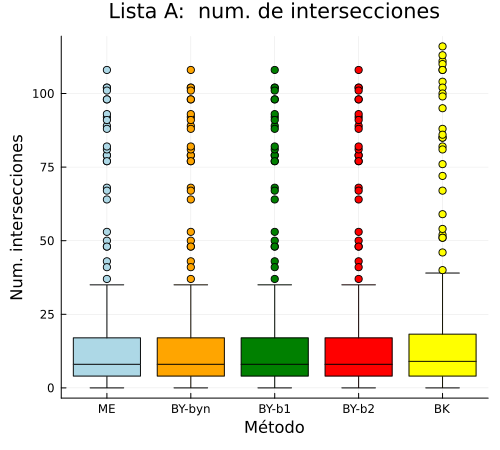

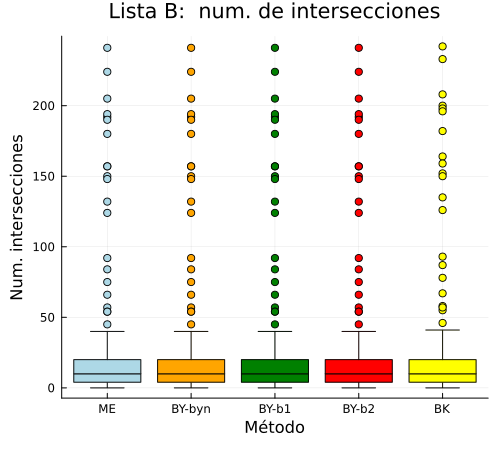

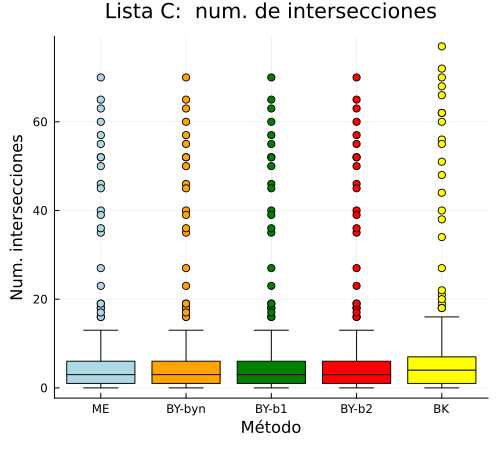

In [24]:
for e in ["A", "B", "C"]
    graficar(e,    [df_global[e]["ME"].Longitudes,
                   df_global[e]["BY-byn"].Longitudes,
                   df_global[e]["BY-b1"].Longitudes,
                   df_global[e]["BY-b2"].Longitudes,    
                   df_global[e]["BK"].Longitudes], " num. de intersecciones", "Num. intersecciones")   
end    

### Tiempo de ejecución

En este grupo de gráficas se observa que el algoritmo que tardó mucho más tiempo que los otros 4 fue el de melding, teniendo una media aproximada de $1.2\times10^5$ nanosegundos un valor bastante pequeño pero aún así mucho mayor a comparación de los otros. 
Vemos que el algoritmo de melding tuvo mayores tiempos registrados en la lista B, a diferencia del conjunto C que se esperaría fuera mayor tiempo debido a las comparaciones mayoritarias que tenía que realizar, pero dado que se tenian que tener elementos comunes para 4 conjuntos era facil descartar en este caso si no existía en alguno, disminuyendo así el número de comparaciones y por lo tanto el tiempo, de forma que los valores de tiempos para melding de menor a mayor para cada lista quedan como A, C y B.

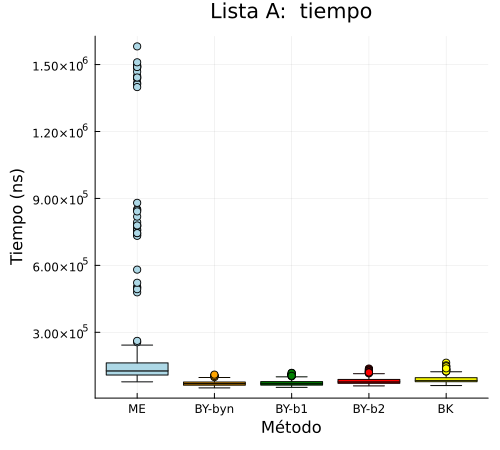

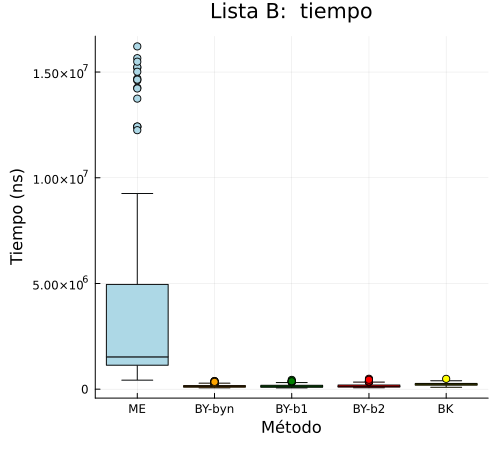

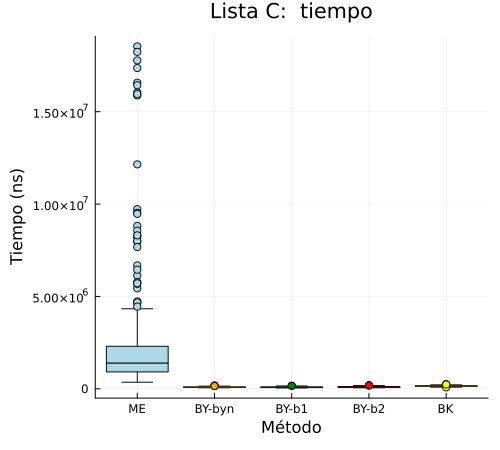

In [25]:
for e in ["A", "B", "C"]
    graficar(e,    [df_global[e]["ME"].Benchmark,
                   df_global[e]["BY-byn"].Benchmark,
                   df_global[e]["BY-b1"].Benchmark,
                   df_global[e]["BY-b2"].Benchmark,    
                   df_global[e]["BK"].Benchmark], " tiempo", "Tiempo (ns)")   
end    

### Número de operaciones

Viendo ahora el número de operaciones tenemos que las comparaciones concuerdan en la distribución para melding como en los tiempos, siendo que la lista que le tomó realizar mayor número de operaciones fue en la lista B, las cuales estan entre 20000 y 70000 operaciones aproximadamente la mayor cantidad de operaciones calculadas, mientras que en la lista C tiene una media de 25000 comparaciones.

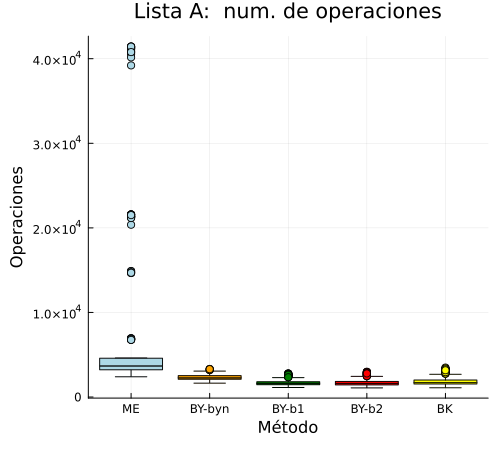

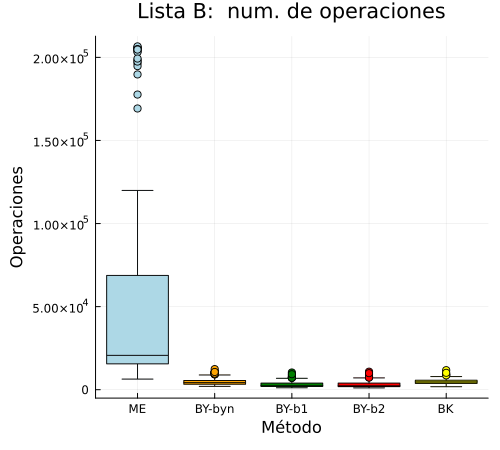

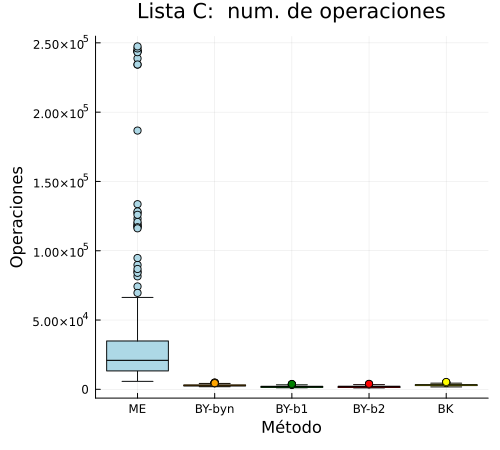

In [26]:
for e in ["A", "B", "C"]
    graficar(e,    [df_global[e]["ME"].Operaciones,
                   df_global[e]["BY-byn"].Operaciones,
                   df_global[e]["BY-b1"].Operaciones,
                   df_global[e]["BY-b2"].Operaciones,    
                   df_global[e]["BK"].Operaciones], " num. de operaciones", "Operaciones")   
end    

## Gráficas sin Melding

Para poder apreciar de mejor forma los resultados de tiempos y número de operaciones del resto de los algoritmos se harán nuevamente las gráficas pero sin el algoritmo de Melding, por lo que se implementa la función `graficar2` para visualizar los datos. 

In [27]:
function graficar2(S, df, titulo, ynombre)

    datosC = DataFrame(BYbin =df[1],
                      BYb1 =df[2],
                      BYb2 =df[3],
                      BK = df[4])
        
    p = boxplot([datosC.BYbin, datosC.BYb1, datosC.BYb2, datosC.BK], 
            xticks=(1:4, ["BY-byn", "BY-b1", "BY-b2", "BK"]), 
            size = (500, 450),
            title=string("Lista ", S ,": ",titulo),
            ylabel=ynombre,
            xlabel="Método",
            color=[:orange :green :red :yellow],
            legend=false)
    display(p)
end    

graficar2 (generic function with 1 method)

### Tiempo de ejecución
Podemos ver que para todas las listas el algoritmo que le tomó más tiempo en terminar fue el BK, algo que nos sorprende dado que de acuerdo al articulo [[7](#referencias)] tiene mejor desempeño, sin embargo se pasaron los conjuntos ordenados por tamaño y sin ordenar pero siempre se obtuvieron los mismos resultados de tiempo, la lista que le tomó más tiempo en procesar fue la lista B.

Por otro lado, las parametrizaciones para BY, quien mantuvo un margen de tiempo inferior a los demás fue con la búsqueda binaria, incluso para la lista C de 4 conjuntos, vemos que en la lista A se incrementó el tiempo de BY con b2, esto debido a que los saltos que daba eran muy grandes y b1 tenía que volver a hacer la búsqueda para esos conjuntos. 

En general se observan mayor número de valores atípicos para la lista A que para las listas B y C por lo que para probar el desempeño de estos algoritmos es conveniente hacerlo con intersecciones de más de 3 conjuntos. 

La lista en la que se obtuvieron menores tiempos para los 4 algoritmos fue en la lista C. Esto lo atribuimos a que era más fácil descartar elementos de búsqueda una vez que no se encontraba alguno en común al menos para 2 conjuntos.

Con los nuevos ajustes para el algoritmo de BY de solo intersectar conforme a los índices y al final reconstruir el resultado solo se mejoraron los tiempos para la lista A, siendo que para las listas B y C se incrementaron, por lo que no es conveniente usarlo cuando ya se tienen listas ordenadas sino solo en caso de no ser ordenadas.

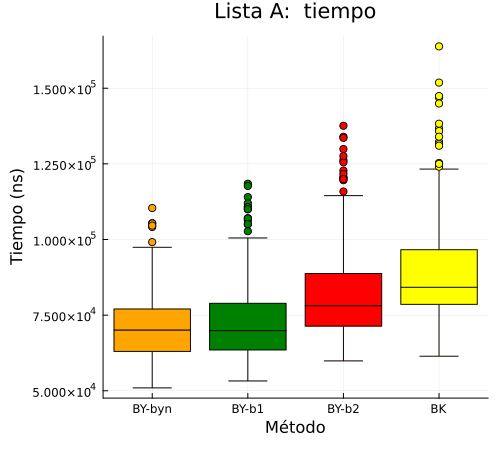

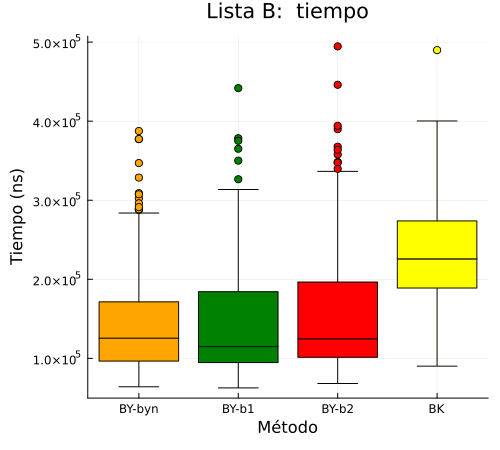

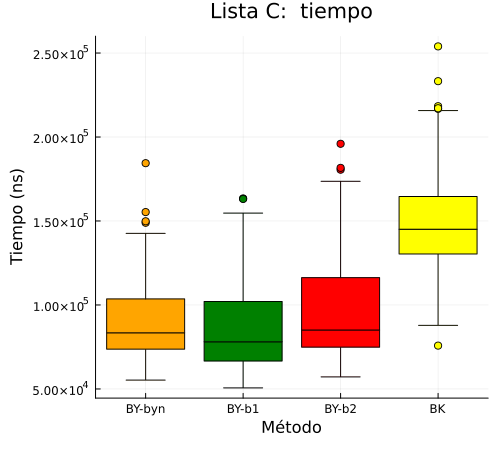

In [28]:
for e in ["A", "B", "C"]
    graficar2(e,    [df_global[e]["BY-byn"].Benchmark,
                   df_global[e]["BY-b1"].Benchmark,
                   df_global[e]["BY-b2"].Benchmark,    
                   df_global[e]["BK"].Benchmark], " tiempo", "Tiempo (ns)")   
end    

### Número de operaciones

Se observa que el número de operaciones para BY parametrizado con binarysearch sobresale con el mayor número de operaciones a diferencia del resto de los algoritmos, vemos que en este caso no tiene el mismo comportamiento con respecto de las gráficas de tiempo, aunque el total de comparaciones es muy similar al BK para la lista C. Se ve una mayor diferencia de los algoritmos de BY-binarysearch con BK para la lista A, aunque los valores atípicos son sobresalientes en la lista A, viendo que la lista A no tiene distribuciones óptimas para la evaluación de estos algoritmos, siendo que uno de los factores sean el tamaño de los conjuntos. 

Por otro lado, los algoritmos que tuvieron menor número de operaciones para todas las listas fue BY parametrizado con b1 y b2, teniendo valores similares en las listas A y C con medias de 1600 y 1350 de operaciones aproximadas respectivamente. 

El hecho de que el número de operaciones haya resultado similar con los algoritmos BY-b1 y BY-b2 puede ser que se hayan posicionado equivocadamente las variables de contar operaciones y también que los pasos de b2 hayan sido muy amplios que b1 tuvo que volver a buscar esas posiciones.

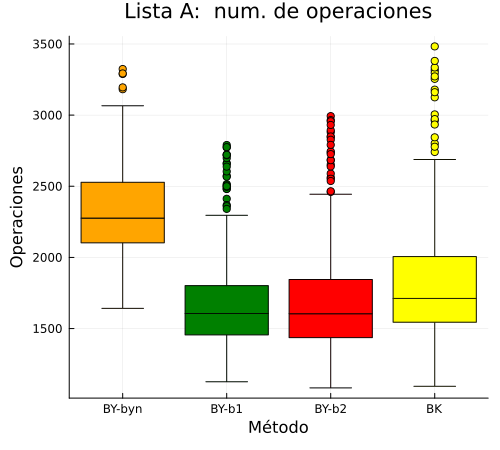

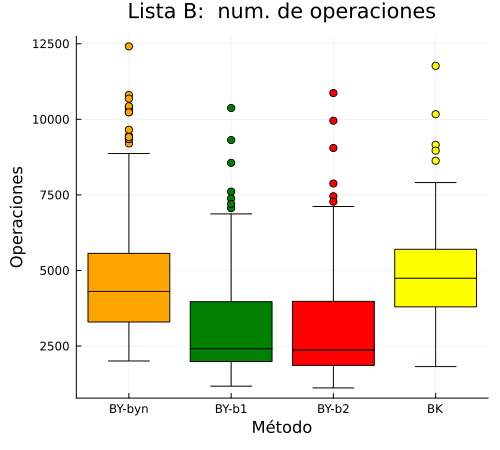

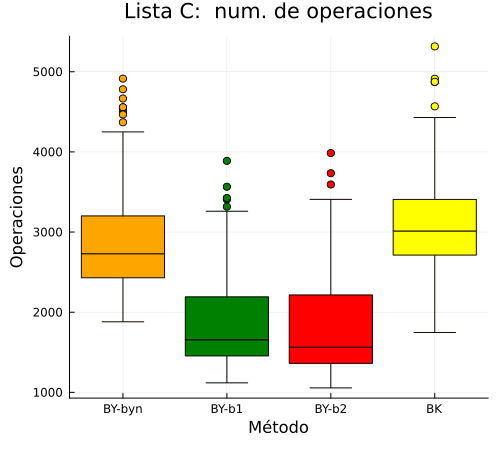

In [29]:
for e in ["A", "B", "C"]
    graficar2(e,    [df_global[e]["BY-byn"].Operaciones,
                   df_global[e]["BY-b1"].Operaciones,
                   df_global[e]["BY-b2"].Operaciones,    
                   df_global[e]["BK"].Operaciones], " num. de operaciones", "Operaciones")   
end   

# Conclusiones 

Para esta práctica se enfocaron esfuerzos en implementar el código de la forma más conveniente para agalizar la toma de métricas, además varios de los algoritmos utlizados en esta práctica fueron tomados como base del sitio [[3](#referencias)] para asegurar la implementación de los mismos, por supuesto hubo implementaciones propias siendo el de ME y las intersecciones multiples para BY.  En el caso del algoritmo BY, se realizaron ajustes para manejar conjuntos ordenados, lo que permitió un mejor desempeño en comparación con la versión inicial.  

Observamos que las mediciones obtenidas no son consistentes con lo reportado en el artículo [[7](#referencias)], lo que nos indica que las evaluaciones se hicieron de forma diferente como lo indicamos en la implementación de BY. En particular, el algoritmo BY-b2 no alcanzó el número de operaciones esperado, teniendo un desempeño inferior de acuerdo al teórico [[5](#referencias)].  

Respecto a los valores atípicos, se identificó que son más frecuentes al trabajar con solo 2 conjuntos, mientras que disminuyen al utilizar 3 o más conjuntos, siendo que a una mayor cantidad de datos se reduce la dispersión en los resultados. Por otro lado, el algoritmo que registró los mayores tiempos y operaciones fue el de melding, destacándose como el menos eficiente en estos experimentos.  

Sin embargo se detectaron errores de intersecciones para el algoritmo de BK, ya que registró longitudes de intersecciones ligeramente mayores que el resto. Este trabajo fue un gran reto para poder generar las medidas de desempeño así como hacer los ajustes para contar operaciones y en  algunos casos la implementación para más de dos conjuntos, por lo que la mayor parte de los esfuerzos se enfocaron en diseñar las medidas de desempeño y no tanto en cómo modificar los algoritmos para que pudieran generar intersecciones de forma adaptativa.

Con los nuevos ajustes para el algoritmo de BY de solo intersectar conforme a los índices y al final reconstruir el resultado solo se mejoraron los tiempos para la lista A, siendo que para las listas B y C se incrementaron, por lo que no es conveniente usarlo cuando ya se tienen listas ordenadas sino solo en caso de no ser ordenadas.

Como trabajo futuro, se plantean mejoras adaptativas, especialmente en BK, con el fin de corregir el algoritmo de BK para que tenga las mismas intersecciones que el resto de los algoritmos y que se obtengan valores cercanos a los resultados de los artículos.

# Referencias
[1] R. Baeza-Yates, "A fast set intersection algorithm for sorted sequences," in *Combinatorial Pattern Matching: 15th Annual Symposium, CPM 2004, Istanbul, Turkey, July 5-7, 2004. Proceedings 15*, 2004, pp. 400–408

[2] J. Barbay and C. Kenyon, "Adaptive intersection and t-threshold problems," in *Proceedings of the Thirteenth Annual ACM-SIAM Symposium on Discrete Algorithms (SODA '02)*, 2002, pp. 390–399. 

[3] SADIT, "Capítulo 6: Intersecciones de Conjuntos," ALGO-IR, [Online]. Available: https://sadit.github.io/ALGO-IR/cap6-intersecciones.html. Accessed: May 15 2025.

[4] E. D. Demaine, A. López-Ortiz, and J. I. Munro, "Adaptive set intersections, unions, and differences," in Proceedings of the Eleventh Annual ACM-SIAM Symposium on Discrete Algorithms, 2000, pp. 743–752.

[5] J. L. Bentley and A. C.-C. Yao, "An almost optimal algorithm for unbounded searching," Information Processing Letters, vol. 5, no. 3, pp. 82-87, 1976.

[6]  SADIT, "Capítulo 5: Búsqueda en Conjuntos Ordenados," ALGO-IR, 2023. [Online]. Available: https://sadit.github.io/ALGO-IR/cap5-busqueda.html. Accessed: May 15, 2025

[7] J. Barbay, A. López-Ortiz, T. Lu, and A. Salinger, "An experimental investigation of set intersection algorithms for text searching," Journal of Experimental Algorithmics (JEA), vol. 14, pp. 3-7, 2010.